**Team Fatboys 5 Updates Report:**

1. Per Jovo's suggestion, we have used quantitative methods (ARI) to evaluate the clustering rather than just doing it visually. 

2. Per Jovo's suggestion, we should make sure that the 2 synap markers and the 2 VGlut1 markers are strongly correlated. We did a scatterplot of the data points. 

3. We performed the same analysis as before on features 3 and 4 (Distance to Center of Mass and Moment of Inertia) in addition to just the integrated and local brightness. 
4. We performed the same analysis as before on additional markers in addition to just the excitatory and inhibitory ones, i.e. the ones that are labeled Synap and others. 

In [25]:
# load all necessary dependencies and load in the log transformed data 
# for both integrated and local intensity

import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import pickle

from sklearn import cross_validation
from sklearn.cross_validation import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


N = 1000 # number of samples at each iteration

dataFile = open('local_processed.p')
localData = pickle.load(dataFile)
dataFile = open('integrated_processed.p')
integratedData = pickle.load(dataFile)
dataFile = open('distCenter_processed.p')
distData = pickle.load(dataFile)
dataFile = open('momentInertia_processed.p')
momData = pickle.load(dataFile)

In [26]:
markers = ['Synap','Synap','VGlut1','VGlut1','VGlut2','Vglut3',
              'psd','glur2','nmdar1','nr2b','gad','VGAT',
              'PV','Gephyr','GABAR1','GABABR','CR1','5HT1A',
              'NOS','TH','VACht','Synapo','tubuli','DAPI']

synapType = ['synap','synap','ex.pre','ex.pre','ex.pre','in.pre',
                  'ex.post','ex.post','ex.post','ex.post','in.pre','in.pre',
                  'in.pre','in.post','in.post','in.post','other','other',
                  'other','other','other','other','none','none']


# filter synapses such that only the ones with high synapsin expression will be accepted.
# add additional synapse filter so we include only those that have a high moment of inertia and large synapsin area 
avglocSynap1 = np.mean(localData[1])
avgintSynap1 = np.mean(integratedData[1])
avgdistSynap1 = np.mean(distData[1])
avgmomSynap1 = np.mean(momData[1])

intfilteredSynapse1 = [synapse for synapse, value in enumerate(integratedData[1]) if value > avgintSynap1]
locfilteredSynapse1 = [synapse for synapse, value in enumerate(localData[1]) if value > avglocSynap1]   
distfilteredSynapse1 = [synapse for synapse, value in enumerate(distData[1]) if value > avgdistSynap1]
momfilteredSynapse1 = [synapse for synapse, value in enumerate(momData[1]) if value > avgmomSynap1]   

highSynapsin1 = set(intfilteredSynapse1).intersection(locfilteredSynapse1)
highArea1 = set(distfilteredSynapse1).intersection(momfilteredSynapse1)

filteredSynapses1 = list(highSynapsin1.intersection(highArea1))

avglocSynap2 = np.mean(localData[2])
avgintSynap2 = np.mean(integratedData[2])
avgdistSynap2 = np.mean(distData[2])
avgmomSynap2 = np.mean(momData[2])

intfilteredSynapse2 = [synapse for synapse, value in enumerate(integratedData[2]) if value > avgintSynap2]
locfilteredSynapse2 = [synapse for synapse, value in enumerate(localData[2]) if value > avglocSynap2] 
distfilteredSynapse2 = [synapse for synapse, value in enumerate(distData[2]) if value > avgdistSynap2]
momfilteredSynapse2 = [synapse for synapse, value in enumerate(momData[2]) if value > avgmomSynap2]  

highSynapsin2 = set(intfilteredSynapse2).intersection(locfilteredSynapse2)
highArea2 = set(distfilteredSynapse2).intersection(momfilteredSynapse2)

filteredSynapses2 = list(set(intfilteredSynapse2).intersection(locfilteredSynapse2))

filteredSynapses = list(set(filteredSynapses1).intersection(filteredSynapses2))

# filter away synapses such that those with high tubulin expression will not be accepted

avgloctub = np.mean(localData[24])
avginttub = np.mean(integratedData[24])
avgdisttub = np.mean(distData[24])
avgmomtub = np.mean(momData[24])

intfilteredtub = [synapse for synapse, value in enumerate(integratedData[24]) if value < avginttub]
locfilteredtub = [synapse for synapse, value in enumerate(localData[24]) if value < avgloctub]
distfilteredtub = [synapse for synapse, value in enumerate(distData[24]) if value < avgdisttub]
momfilteredtub = [synapse for synapse, value in enumerate(momData[24]) if value < avgmomtub]  

areafilteredtub = list(set(distfilteredtub).intersection(momfilteredtub))

intensityfilteredtub = list(set(intfilteredtub).intersection(locfilteredtub))

finaltubFiltered = list(set(intensityfilteredtub).intersection(areafilteredtub))


finalFilteredInd = list(set(finaltubFiltered).intersection(filteredSynapses))

# now that we have the valid synapses, we only want certain features...
# i.e. the inhibitory and the excitatory ones

exAndInMarkerInd = [i for i,j in enumerate(synapType) if j[0:2] == 'in' or j[0:2]=='ex']
otherMarkerInd = [i for i,j in enumerate(synapType) if j[0:5] == 'other' or j[0:5 == 'Synap']]

# finalized filtered data
exAndInIntData =  np.asarray([integratedData[i][q] for i in exAndInMarkerInd \
                               for q in finalFilteredInd]).reshape(len(finalFilteredInd),len(exAndInMarkerInd))
exAndInLocData =  np.asarray([localData[i][q] for i in exAndInMarkerInd \
                               for q in finalFilteredInd]).reshape(len(finalFilteredInd),len(exAndInMarkerInd))
exAndInDistData =  np.asarray([distData[i][q] for i in exAndInMarkerInd \
                               for q in finalFilteredInd]).reshape(len(finalFilteredInd),len(exAndInMarkerInd))
exAndInMomData =  np.asarray([momData[i][q] for i in exAndInMarkerInd \
                               for q in finalFilteredInd]).reshape(len(finalFilteredInd),len(exAndInMarkerInd))

otherIntData =  np.asarray([integratedData[i][q] for i in otherMarkerInd \
                               for q in finalFilteredInd]).reshape(len(finalFilteredInd),len(otherMarkerInd))
otherLocData =  np.asarray([localData[i][q] for i in otherMarkerInd \
                               for q in finalFilteredInd]).reshape(len(finalFilteredInd),len(otherMarkerInd))
otherDistData =  np.asarray([distData[i][q] for i in otherMarkerInd \
                               for q in finalFilteredInd]).reshape(len(finalFilteredInd),len(otherMarkerInd))
otherMomData =  np.asarray([momData[i][q] for i in otherMarkerInd \
                               for q in finalFilteredInd]).reshape(len(finalFilteredInd),len(otherMarkerInd))


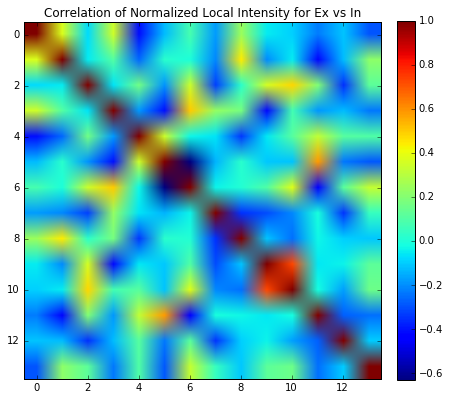

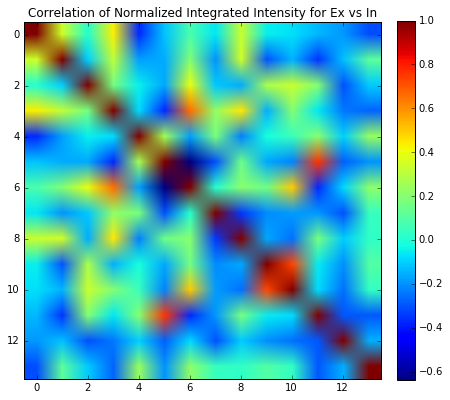

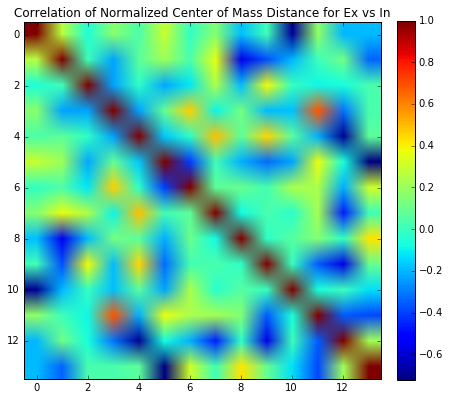

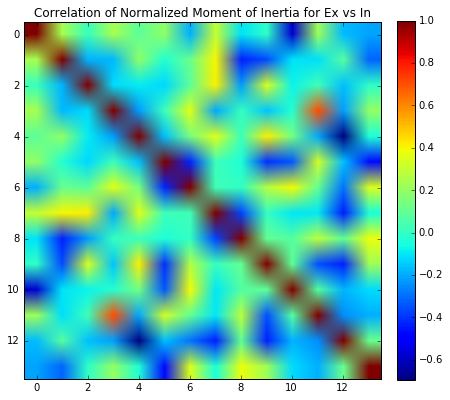

In [27]:
np.random.seed(1)  # for reproducibility, set random seed
randPermute = np.random.permutation(range(0,len(finalFilteredInd)))
randSample = randPermute[0:N]

exAndInLocFeatures = exAndInLocData[randSample,:]
exAndInIntFeatures = exAndInIntData[randSample,:]
exAndInDistFeatures = exAndInDistData[randSample,:]
exAndInMomFeatures = exAndInMomData[randSample,:]

otherLocFeatures = otherLocData[randSample,:]
otherIntFeatures = otherIntData[randSample,:]
otherDistFeatures = otherDistData[randSample,:]
otherMomFeatures = otherMomData[randSample,:]

rExAndIn = len(exAndInMarkerInd)
rOther = len(otherMarkerInd)

%matplotlib inline

exAndInCorrLocal = np.empty([rExAndIn,rExAndIn])
for i in range(0,rExAndIn):
    for j in range(0,rExAndIn):
        results = np.corrcoef(exAndInLocFeatures[i,:],exAndInLocFeatures[j,:])
        exAndInCorrLocal[i,j] = results[1,0]

plt.figure(figsize=(7,7))
im = plt.imshow(exAndInCorrLocal)
plt.title('Correlation of Normalized Local Intensity for Ex vs In')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.show()


exAndInCorrIntegrated = np.empty([rExAndIn,rExAndIn])
for i in range(0,rExAndIn):
    for j in range(0,rExAndIn):
        results = np.corrcoef(exAndInIntFeatures[i,:],exAndInIntFeatures[j,:])
        exAndInCorrIntegrated[i,j] = results[1,0]

plt.figure(figsize=(7,7))
im = plt.imshow(exAndInCorrIntegrated)
plt.title('Correlation of Normalized Integrated Intensity for Ex vs In')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.show()

exAndInCorrDist = np.empty([rExAndIn,rExAndIn])
for i in range(0,rExAndIn):
    for j in range(0,rExAndIn):
        results = np.corrcoef(exAndInDistFeatures[i,:],exAndInDistFeatures[j,:])
        exAndInCorrDist[i,j] = results[1,0]

plt.figure(figsize=(7,7))
im = plt.imshow(exAndInCorrDist)
plt.title('Correlation of Normalized Center of Mass Distance for Ex vs In')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.show()

exAndInCorrMom = np.empty([rExAndIn,rExAndIn])
for i in range(0,rExAndIn):
    for j in range(0,rExAndIn):
        results = np.corrcoef(exAndInMomFeatures[i,:],exAndInMomFeatures[j,:])
        exAndInCorrMom[i,j] = results[1,0]

plt.figure(figsize=(7,7))
im = plt.imshow(exAndInCorrMom)
plt.title('Correlation of Normalized Moment of Inertia for Ex vs In')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.show()



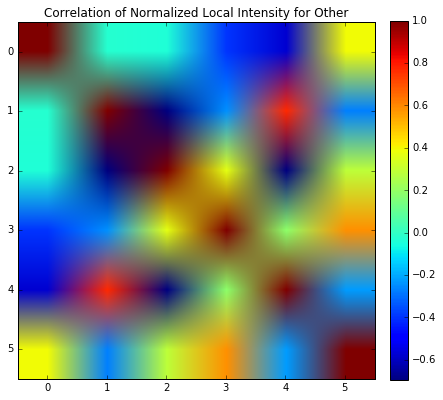

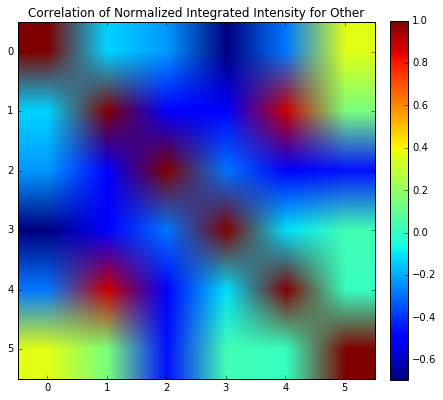

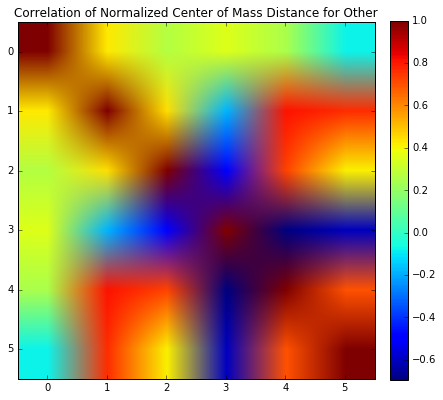

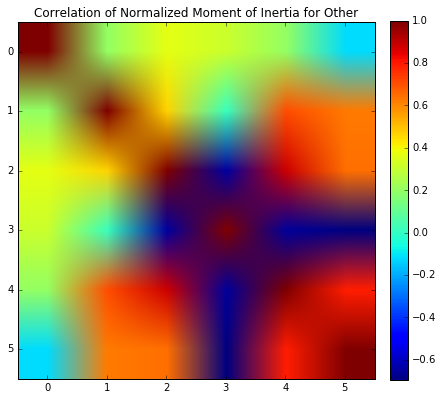

In [28]:
otherCorrLocal = np.empty([rOther,rOther])
for i in range(0,rOther):
    for j in range(0,rOther):
        results = np.corrcoef(otherLocFeatures[i,:],otherLocFeatures[j,:])
        otherCorrLocal[i,j] = results[1,0]

plt.figure(figsize=(7,7))
plt.imshow(otherCorrLocal)
plt.title('Correlation of Normalized Local Intensity for Other')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.show()


otherCorrIntegrated = np.empty([rOther,rOther])
for i in range(0,rOther):
    for j in range(0,rOther):
        results = np.corrcoef(otherIntFeatures[i,:],otherIntFeatures[j,:])
        otherCorrIntegrated[i,j] = results[1,0]

plt.figure(figsize=(7,7))
plt.imshow(otherCorrIntegrated)
plt.title('Correlation of Normalized Integrated Intensity for Other')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.show()

otherCorrDist = np.empty([rOther,rOther])
for i in range(0,rOther):
    for j in range(0,rOther):
        results = np.corrcoef(otherDistFeatures[i,:],otherDistFeatures[j,:])
        otherCorrDist[i,j] = results[1,0]

plt.figure(figsize=(7,7))
plt.imshow(otherCorrDist)
plt.title('Correlation of Normalized Center of Mass Distance for Other')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.show()

otherCorrMom = np.empty([rOther,rOther])
for i in range(0,rOther):
    for j in range(0,rOther):
        results = np.corrcoef(otherMomFeatures[i,:],otherMomFeatures[j,:])
        otherCorrMom[i,j] = results[1,0]

plt.figure(figsize=(7,7))
plt.imshow(otherCorrMom)
plt.title('Correlation of Normalized Moment of Inertia for Other')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.show()

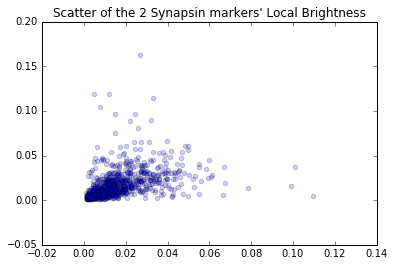

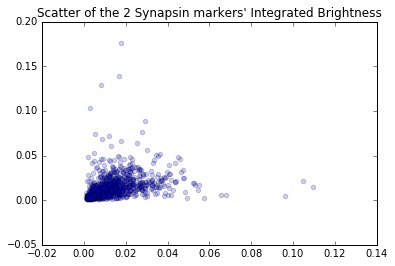

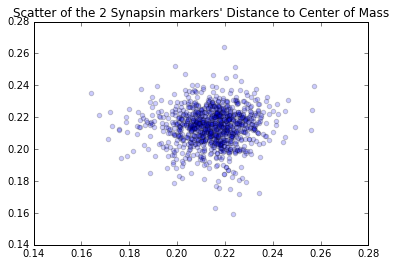

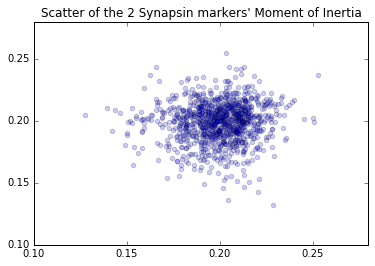

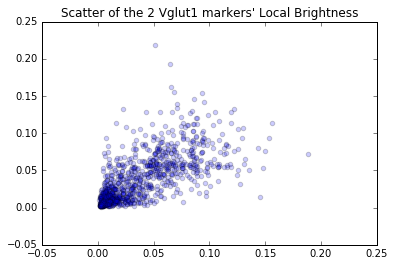

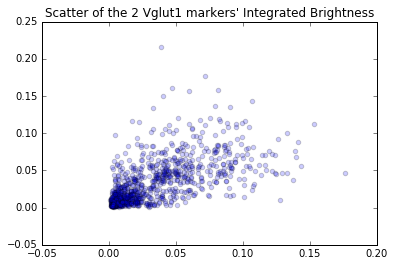

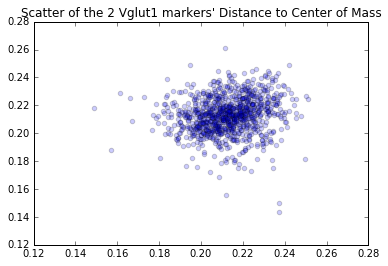

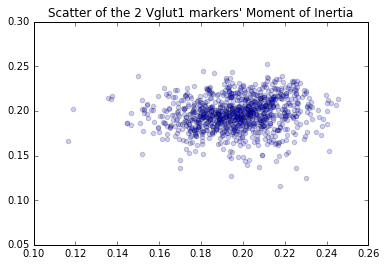

In [29]:
# scatter the 2 synap1 and the 2 vglut1 
firstSynapLoc = otherLocData[randSample,0]
firstSynapInt = otherIntData[randSample,0]
firstSynapDist = otherDistData[randSample,0]
firstSynapMom = otherMomData[randSample,0]

secondSynapLoc = otherLocData[randSample,1]
secondSynapInt = otherIntData[randSample,1]
secondSynapDist = otherDistData[randSample,1]
secondSynapMom = otherMomData[randSample,1]

firstVGlutLoc = exAndInLocData[randSample,0]
firstVGlutInt = exAndInIntData[randSample,0]
firstVGlutDist = exAndInDistData[randSample,0]
firstVGlutMom = exAndInMomData[randSample,0]

secondVGlutLoc = exAndInLocData[randSample,1]
secondVGlutInt = exAndInIntData[randSample,1]
secondVGlutDist = exAndInDistData[randSample,1]
secondVGlutMom = exAndInMomData[randSample,1]


plt.scatter(firstSynapLoc, secondSynapLoc,alpha=0.2)
plt.title("Scatter of the 2 Synapsin markers' Local Brightness")
plt.show()
plt.scatter(firstSynapInt, secondSynapInt,alpha=0.2)
plt.title("Scatter of the 2 Synapsin markers' Integrated Brightness")
plt.show()
plt.scatter(firstSynapDist, secondSynapDist,alpha=0.2)
plt.title("Scatter of the 2 Synapsin markers' Distance to Center of Mass")
plt.show()
plt.scatter(firstSynapMom, secondSynapMom,alpha=0.2)
plt.title("Scatter of the 2 Synapsin markers' Moment of Inertia")
plt.show()
plt.scatter(firstVGlutLoc, secondVGlutLoc,alpha=0.2)
plt.title("Scatter of the 2 Vglut1 markers' Local Brightness")
plt.show()
plt.scatter(firstVGlutInt, secondVGlutInt,alpha=0.2)
plt.title("Scatter of the 2 Vglut1 markers' Integrated Brightness")
plt.show()
plt.scatter(firstVGlutDist, secondVGlutDist,alpha=0.2)
plt.title("Scatter of the 2 Vglut1 markers' Distance to Center of Mass")
plt.show()
plt.scatter(firstVGlutMom, secondVGlutMom,alpha=0.2)
plt.title("Scatter of the 2 Vglut1 markers' Moment of Inertia")
plt.show()

0.594929804776
0.594929804776


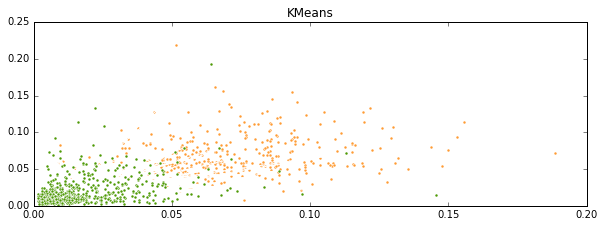

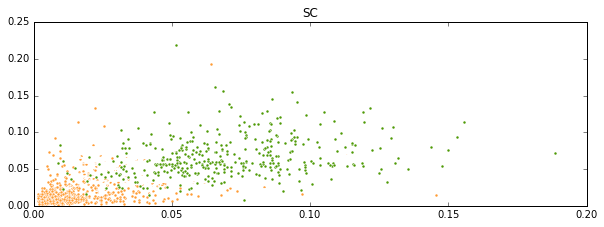

In [44]:
from sklearn import metrics
from sklearn.cluster import KMeans

meanVGlut1Loc = np.mean(firstVGlutLoc)

VGlut1PosLoc = [firstVGlutLoc[i] > meanVGlut1Loc for i in range(0,len(exAndInLocFeatures[:]))]

g = lambda x: 1 if x else 0

VGlut1LocLabel = [g(i) for i in VGlut1PosLoc]

KM = KMeans(init='k-means++', n_clusters=2)
KM.fit(exAndInLocFeatures[0:1000,:])

k_means_labels = KM.labels_
k_means_cluster_centers = KM.cluster_centers_

fig = plt.figure(figsize=(8, 3))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ['#FF9C34', '#4E9A06']

ax = fig.add_subplot(1, 1, 1)

for k, col in zip(range(2), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(exAndInLocFeatures[my_members, 0], exAndInLocFeatures[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    
ax.set_title('KMeans')

print metrics.adjusted_rand_score(VGlut1LocLabel, k_means_labels)  

from sklearn.cluster import SpectralClustering

SC = SpectralClustering(n_clusters=2)
SC.fit(exAndInLocFeatures[0:1000,:])

SC_labels = SC.labels_

fig = plt.figure(figsize=(8, 3))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ['#FF9C34', '#4E9A06']

ax = fig.add_subplot(1, 1, 1)

for k, col in zip(range(2), colors):
    my_members = SC_labels == k
    ax.plot(exAndInLocFeatures[my_members, 0], exAndInLocFeatures[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    
ax.set_title('SC')

print metrics.adjusted_rand_score(VGlut1LocLabel, SC_labels)  